### Functions to calculate biophysical properties based on the protein sequence

In [2]:
import os
import pandas as pd
import numpy as np
import json
import requests
import pickle
from PIL import Image
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.ProtParam import ProtParamData

######  3 classes: (1) Droplet drivers (2) +Amyloids (3) -PT

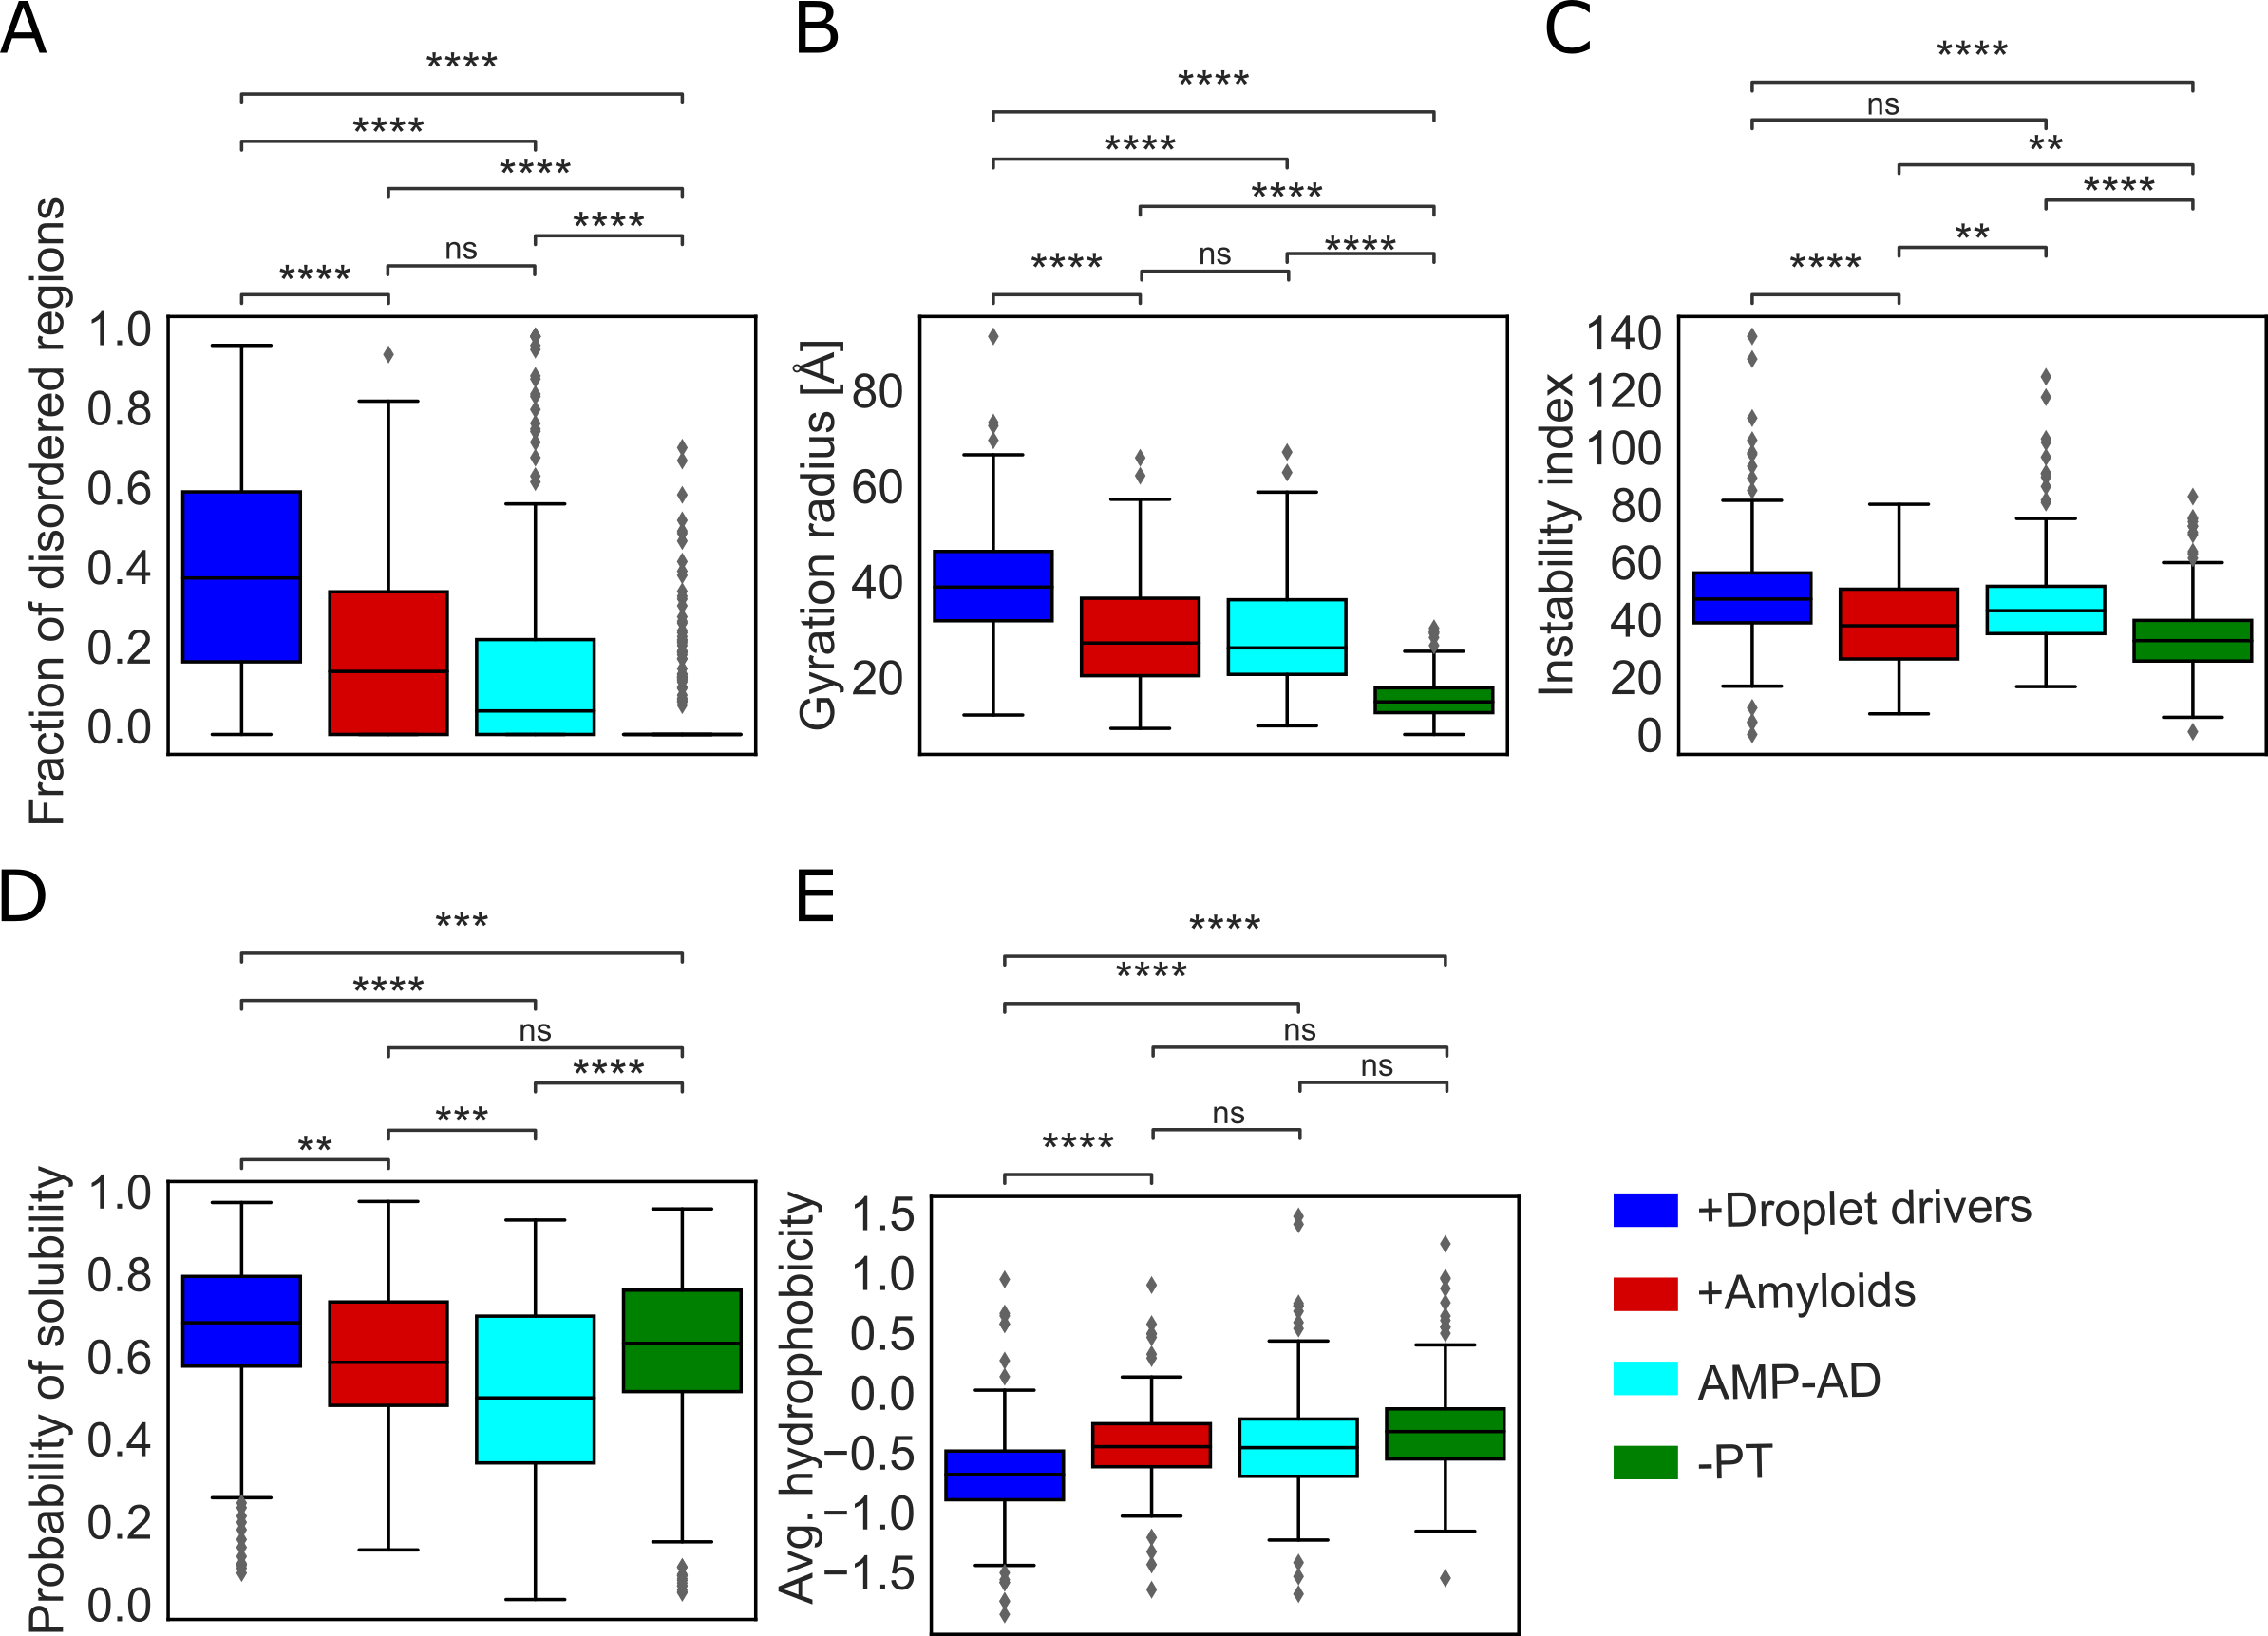

In [7]:
img = Image.open('properties.png')
img

In [9]:
#### load +Droplet drivers class ####


### uniprot ID
with open('final_files/gr_uniprot_id_d_404', 'rb') as fp:
                        gr_uniprot_id_d_404 = pickle.load(fp)

# +Droplet drivers sequences        
with open('final_files/gr_protein_seq_d_404', 'rb') as fp:
                        gr_protein_seq_d_404 = pickle.load(fp)
        
###### +Droplet driver features (biophysical properties) ######

## iupred3 disorder score
with open('final_files/disorder_d_404', 'rb') as fp:
                        disorder_d_404= pickle.load(fp)
        

## gyration radious
with open('final_files/droplet_driver_r_g_d_404', 'rb') as fp:
                       droplet_driver_r_g_d_404 = pickle.load(fp)

In [3]:
## load +Amyloids class

### uniprot ID
with open('final_files/gr_uniprot_id_a_113', 'rb') as fp:
                        gr_uniprot_id_a_113 = pickle.load(fp)
        
        
### +Amyloids sequences        
with open('final_files/gr_protein_seq_a_113', 'rb') as fp:
                        gr_protein_seq_a_113 = pickle.load(fp)

###### +Amyloids features (biophysical properties) ######

## iupred3 disorder score
with open('final_files/disorder_a_113', 'rb') as fp:
                        disorder_a_113 = pickle.load(fp)

## gyration radious
with open('final_files/amyloid_r_g_a_113', 'rb') as fp:
                       amyloid_r_g_a_113 = pickle.load(fp)       

#### Gyration radious

In [13]:
def pointer_state(pdb_file_l, state):
    
    "input: folder state where pdb files are stored: droplets / amyloid /" 
    "droplets and amyloids / structured"
    "pdb files - list of pdb file names stored in folder"
    "output: path to pdb files"
    
    # intiate gyration radious and rho calculations

    f_name = pdb_file_l

    prot = pd.DataFrame(data = f_name, columns = ['ID']) #construct dataframe
    #prot['file_name'] = [PDBList().retrieve_pdb_file(p,file_format='pdb').replace(directory,'.') for p in prot['ID']]

    d = {'file_name': f_name}
    prot['file_name'] = pd.DataFrame(data=d)

    # choose 
    state = f'{state}'

    #prot['pointer'] = [open(f'/Users/morfrank/multi_scale_modeling/pdb/{state}/{name}', 'r') for name in prot['file_name']]
    prot['pointer'] = [open(f'{state}/{name}', 'r') for name in prot['file_name']]
    #this will store the file pointers within a column of the dataframe

    return prot['pointer']

In [8]:
def atomize_correct(pdbfile, heteroatom=False):


    pdbfile.seek(0) #setting readlines to 0
    atoms = np.array([line for line in pdbfile.readlines()])
    atoms = pd.Series(atoms[[('ATOM' in line[:10]) or (('HETATM' in line[:10]) & heteroatom)
                                     for line in atoms]]).str.split(expand=True)

    #.pdb files seem to have spacing errors and so we need to fix some things before we can use the numbers
    #fixing non 3 proteins with shifted tables
    mask = ((atoms.iloc[:,3].str.len()!=3) & (atoms.iloc[:,4].str.isnumeric()))
    atoms.loc[mask,5:] = np.array(atoms.loc[mask,4:10])

    #fix all the non 3 proteins
    mask = (atoms.iloc[:,3].str.len()!=3)
    if np.any(mask):
                joint = atoms.loc[mask,2:4].agg(''.join,axis=1).str.replace('\d+','').copy()
                atoms.loc[mask,4] = joint.str[-1]
                atoms.loc[mask,3] = joint.str[-4:-1]
                atoms.loc[mask,2] = joint.str[:-4]

    #fix the none-types due to sticking of B-factor and occupancy
    mask = (np.array(atoms[11])==None)
    if np.any(mask):
                joint = atoms.loc[mask,9:].replace({None:''}).agg(''.join,axis=1)
                atoms.loc[mask,11] = joint.str[-1]
                atoms.loc[mask,10] = joint.str[4:-1]
                atoms.loc[mask,9] = joint.str[:4]
                atoms.loc[mask]

    #giving column names
    cols = ['record','serial','name','residue','chain',
                    'seq-pos','x','y','z','occupancy','B-factor','element']
    atoms.columns = cols

    #specifying data types
    atoms['serial'] = atoms['serial'].astype('int')

    try:
        atoms[['x','y','z','occupancy','B-factor']] = atoms[['x','y','z','occupancy','B-factor']].astype('float')
        atoms = atoms.sort_values(by=['serial'])

    except:

            #### my correction ####
            x=[]
            y=[]
            z=[]
            record = []
            serial = []
            name = []
            residue = []
            chain = []
            seq_pos = []
            occupancy = []
            B_factor = []
            element = []

            n=0


            for i in range(0,atoms.shape[0]):

                try:
                        float(atoms['x'].iloc[i]) 
                        float(atoms['y'].iloc[i]) 
                        float(atoms['z'].iloc[i])
                        atoms['element'].iloc[i]
                        atoms['serial'].iloc[i]

                        x.append(float(atoms['x'].iloc[i]))
                        y.append(float(atoms['y'].iloc[i]))
                        z.append(float(atoms['z'].iloc[i]))
                        element.append((atoms['element'].iloc[i]))
                        #record.append((atoms['record'].iloc[i]))
                        serial.append((atoms['serial'].iloc[i]))
                        #name.append((atoms['name'].iloc[i]))
                        #residue.append((atoms['residue'].iloc[i]))
                        #chain.append((atoms['chain'].iloc[i]))
                        #seq_pos.append((atoms['seq-pos'].iloc[i]))   
                        #occupancy.append(float(atoms['occupancy'].iloc[i]))
                        #B_factor.append(float(atoms['B-factor'].iloc[i]))


                except:
                    continue

            #d = {'record':record,'serial':serial,'name':name,'residue':residue, 
                 #'chain':chain,'seq_pos':seq_pos, 'x': x, 'y': y, 'z': z,
                 #'occupancy':occupancy, 'B_factor':B_factor, 'element':element}
            d = {'x': x, 'y': y, 'z': z, 'serial':serial,'element':element }

            atoms_cc= pd.DataFrame(d)
            atoms = atoms_cc
            #atoms = atoms.sort_values(by=['serial'])
    return atoms

In [9]:
def com(structure):
    com = np.zeros(3)
    mass = structure['element'].replace({'N':14,'C':12,'H':1,'O':16,
                                                               'S':32,'O1-':16}).astype('float')
    M = np.sum(np.array(mass))
    com = mass.dot(structure[['x','y','z']])
    return np.array(com/M)

In [10]:
#Lobanov, M.Y., Bogatyreva, N.S. & Galzitskaya, O.V. Radius of gyration as an indicator of protein structure compactness. Mol Biol 42, 623–628 (2008).
#Rob Phillips, Jane Kondev, Julia Theriot, and Hernan G. Garcia. 1960. Physical Biology of the Cell. Second Edition.
#Chaitanya Athale's Cellular Biophysics Course at IISER Pune
def radius_of_gyration(uniprot_id_save,structure,com):
    N = np.size(np.array(structure['x']))
    Rg2 = np.array(structure[['x','y','z']]-com)
    Rg = np.sqrt((Rg2*Rg2).sum(-1).sum()/N)
    return Rg, uniprot_id_save

In [31]:
## list of pdb files of proteins. We will have 3 lists:
# (1) amyloid forming proteins (class: +Amyloid)
# (2) Droplet drivers forming proteins (class: +Droplet drivers)
# (3) Proteins which very unlikely to undergo phase separation. These are very stable"
      # and well structured proteins, showing low discorder in their structure (class:-PT)

dir_list_protein_state=[]
for file in os.listdir("final_files"):
    if file.endswith(".pdb"):
         dir_list_protein_state.append(file)
len(dir_list_AD_alpha)
dir_list_protein_state

['AF-P05067-F1-model_v4.pdb', 'AF-P10636-F1-model_v4.pdb']

In [72]:
# pdb file names of +Droplet drivers/ a - +Amyloid/ da - +Droplet drivers and - +Amyloid/ -PT - structured

f_name = dir_list_protein_state

pointer_s = pointer_state(f_name , 'final_files')

# gyration radious list d - droplets, a - amyloids, da - droplets and amyloids
r_g_all = []

#save uniprot gyration radious calculation
gr_uniprot_id =[]

#set for EsmFOLD
#uniprot_id_list_a_esm = [i for i in range(0, len(pdb_bank_400))]
gr_seq_AD_alpha = []

# set for adding alphafold pdb
#uniprot_id_list_af_d = [i for i in dir_list]

# Gyration radious calculation
ID = [i for i in range(0,len(f_name))]

for i in ID:
    try:
        r_g, uniprot_s = radius_of_gyration(dir_list_protein_state[i],atomize_correct(pointer_s[i]),com(atomize_correct(pointer_s[i])))
        
        ### gyration radius for each sequence
        r_g_all.append(r_g)
        
        ### list of uniprot id of the gyration radiuses
        gr_uniprot_id.append(uniprot_s.split('.')[0])

    except:
        continue

#### Fraction of disordered regions

for new generated protein sequences we will not have the uniprot id. we need to use
the following command:

!python3 iupred3.py file_name.seq long >score_seq.txt

In [5]:
def disorder(uniprotid):
    
    disorder_score = []
    uniprot = []

    for num, i in enumerate(uniprotid):
        
        try: 
            url = f'http://iupred3.elte.hu/iupred3/{i}.json'
            score_json = json.loads(requests.get(url).text)
            disorder_score.append(score_json['iupred2'])
            uniprot.append(i)
        except:
                f=open(f'/Users/morfrank/multi_scale_modeling/pdb/amyloid/{i}.txt',"r")
                lines=f.readlines()
                result=[]
                for x in lines:
                    result.append(np.float64(x.split("\t",2)[2].split('\t')[0]))
                f.close()
                disorder_score.append(result)
                uniprot.append(i)
                
                continue

    return disorder_score, uniprot

In [15]:
### uniprot id of the protein sequences
uniprotid =['P05067', 'P10636']

disorder_score,uniprot_id = disorder(uniprotid)
disorder_score_ab42 = [[0.3147267520282946, 0.30757679869634236, 0.3186624206569609, 0.3301207218333493, 0.3310834246584782, 0.3165447391018766, 0.28622923169641884, 0.24345969456511168, 0.1940250144478808, 0.14504804172832966, 0.10337788248752602, 0.08708089689054488, 0.08435693121548832, 0.10229522640999233, 0.12019413406916185, 0.13140598815450052, 0.13908389917886277, 0.1379640273253161, 0.13133602840217853, 0.12032204011304382, 0.1055773270964903, 0.08822866455779445, 0.06590555135279202, 0.05273758971596625, 0.04097268676806201, 0.0358100142683997, 0.03325275057207507, 0.03483376766724232, 0.037926014672222105, 0.043256214564534816, 0.04451872553505548, 0.04913452873871574, 0.045834639251571496, 0.03977551698299376, 0.032386031904044245, 0.024799526835863415, 0.018080346233229433, 0.013041721095053138, 0.010063653874864131, 0.008910803391296677, 0.008550369738576084, 0.006969979197005059]]

In [9]:
def fraction_of_disordered_regions(disorder_score):
    "input: list of disorder scores for the amino acids in sequence"
    "output: fraction of disordered-regions in a sequence. a disordered region"
    "is defined by 20 succssive amino acids in the sequence"
    
    num_residues = 0
    num_of_residues_t = 0
    sum_disorder_regions = []
    fraction_disorder = []
    count_disorder = []

    for num in range(0,len(disorder_score)):
        for n,s in enumerate(disorder_score[num]):

                if s >0.5:
                    num_residues = num_residues + 1
                    #print(num_residues)


                if s <0.5 and num_residues >20 :
                    num_of_residues_t = num_of_residues_t + num_residues 
                    sum_disorder_regions.append(num_of_residues_t)
                    num_of_residues_t=0
                    num_residues=0
                    #print(sum_disorder_regions)


                if s >0.5 and num_residues >20 and (n+1)==len(disorder_score[num]) :
                    num_of_residues_t = num_of_residues_t + num_residues 
                    sum_disorder_regions.append(num_of_residues_t)
                    num_of_residues_t=0
                    num_residues=0
                    #print(sum_disorder_regions)


        fraction_disorder.append(np.sum(sum_disorder_regions)/len(disorder_score[num]))
        count_disorder.append(np.sum(sum_disorder_regions))
        sum_disorder_regions = []
        num_of_residues_t=0
        num_residues=0

    
    return fraction_disorder

In [16]:
### calculate for each sequence the fraction of disordered regions
fraction_disorder = fraction_of_disordered_regions(disorder_score_ab42)
fraction_disorder

[0.0]

#### Instability index

In [23]:
## calculate the instability index for each sequence

seq = ['DAEFRHDSGYEVHHQKLVFFAEDVGSNKGANIGLMVGGVVIA']
## user enters his sequence(s)
#seq_class = gr_protein_seq_d_404

#X= [ProteinAnalysis(i) for i in gr_protein_seq_d_404]
X= [ProteinAnalysis(i) for i in seq]
instability_index= [i.instability_index() for i in X]

len(instability_index)
instability_index

[28.633333333333333]

#### Average hydrophobicity

In [11]:
## calculate the average of hydrophobicity for each sequence

## user enters his sequence(s)
seq_class = gr_protein_seq_d_404

X= [ProteinAnalysis(i) for i in gr_protein_seq_d_404]
avg_hydrophbicity = [np.mean(i.protein_scale(ProtParamData.kd, 10, 0.5)) for i in X]

len(avg_hydrophbicity)

404

#### Probability of solubility 

In [21]:
#SWI and probability of solubility. Ref: https://doi.org/10.1093/bioinformatics/btaa578

def SWI_Solubility(df, state):
    "input - dataframe of protein sequence"
    "state: +Droplet drivers, ,AMP-AD, +Amyloids, -PT"
    
    weights = {'A': 0.8356471476582918,
               'C': 0.5208088354857734,
               'E': 0.9876987431418378,
               'D': 0.9079044671339564,
               'G': 0.7997168496420723,
               'F': 0.5849790194237692,
               'I': 0.6784124413866582,
               'H': 0.8947913996466419,
               'K': 0.9267104557513497,
               'M': 0.6296623675420369,
               'L': 0.6554221515081433,
               'N': 0.8597433107431216,
               'Q': 0.789434648348208,
               'P': 0.8235328714705341,
               'S': 0.7440908318492778,
               'R': 0.7712466317693457,
               'T': 0.8096922697856334,
               'W': 0.6374678690957594,
               'V': 0.7357837119163659,
               'Y': 0.6112801822947587, 
               'X':0.75}

    # Constants from logistic fitting
    # prob = 1 / (1 + exp(-(a * x + b)));

    A = 81.0581
    B = -62.7775
    
    
    df['SWI'] = df['Sequence'].apply(lambda x: np.mean([weights[i] for i in x]))
    df['weight_list'] = df['Sequence'].apply(lambda x: ([(weights[i]) for i in x]))
    print('Computing Probability of solubility...', end='\n')
    df['Prob. of Solubility'] = 1/(1 + np.exp(-(A*df['SWI'] + B)))
    print('Exporting file...', end='\n')
    
    ### enable to save probability of solubility to a csv file ###
    #output_fname = os.path.join(os.getcwd(), f'final_files/gr_swi_results_{state}' +'.csv')
    #df.to_csv(output_fname, index=None)
    
    print('Done!')
    
    
    return df

In [22]:
## calculate the Probability of solubility

## user enters his sequence(s)
seq_class = gr_protein_seq_d_404

d = {'Sequence': seq_class}
df = pd.DataFrame(data=d) 
class_of_seq = 'droplets'    ### user enters the sequence class +droplet drivers or +Amyloids

# change the name of the csv output in the SWI_Solubility function
df_prob_sol = SWI_Solubility(df, f'{class_of_seq}')
df_prob_sol

Computing Probability of solubility...
Exporting file...
Done!


,Sequence,SWI,weight_list,Prob. of Solubility
0,MQVPEHVVSLYIATCGQNGSGLGSDEKEIILLVFVLLEVSTGQIVG...,0.778874,"[0.6296623675420369, 0.789434648348208, 0.7357...",0.588211
1,MDHLNEATQGKEHSEMSNNVSDPKGPPAKIARLEQNGSPLGRGRLG...,0.789989,"[0.6296623675420369, 0.9079044671339564, 0.894...",0.778601
2,MEERRPHLDARPRNSHTNHRGPVDGELPPRARNQANNPPANALRGG...,0.777011,"[0.6296623675420369, 0.9876987431418378, 0.987...",0.551201
3,MAKAAAIGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFTD...,0.793267,"[0.6296623675420369, 0.8356471476582918, 0.926...",0.821012
4,MPSGSSAALALAAAPAPLPQPPPPPPPPPPPLPPPSGGPELEGDGL...,0.789703,"[0.6296623675420369, 0.8235328714705341, 0.744...",0.774575
...,...,...,...,...
399,MKGNFRKRDSSTNSRKGGNSDSNYTNGGVPNQNNSSMFYENPEITR...,0.796544,"[0.6296623675420369, 0.9267104557513497, 0.799...",0.856783
400,MEKTLETVPLERKKREKEQFRKLFIGGLSFETTEESLRNYYEQWGK...,0.786816,"[0.6296623675420369, 0.9876987431418378, 0.926...",0.731113
401,MSSAVGPRGPRPPTVPPPMQELPDLSHLTEEERNIIMAVMDRQKEE...,0.792802,"[0.6296623675420369, 0.7440908318492778, 0.744...",0.815402
402,MASLTVKAYLLGKEDAAREIRRFSFCCSPEPEAEAEAAAGPGPCER...,0.788503,"[0.6296623675420369, 0.8356471476582918, 0.744...",0.757132
